In [59]:
import pandas as pd
import numpy as np
import cv2
import os
import re

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

from xml.etree import ElementTree as et

In [60]:
# defining the files directory and testing directory
files_dir = 'data/trainval'
test_dir = 'data/test'


class MaizeTasselDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Maize']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])        
    
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        if len(boxes) !=0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.zeros((1,), dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)

In [61]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.OneOf([
                                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                                     val_shift_limit=0.2, p=0.9),
                                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                           contrast_limit=0.2, p=0.9),
                            ],p=0.9),
                            A.ToGray(p=0.01),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load("fasterrcnn_1.pth", map_location=device))

d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [63]:
# Move the model to the appropriate device
model = model.to(device)

In [64]:
test_data = MaizeTasselDataset(test_dir, 1024, 1024, get_transform(train=False))

In [65]:
model.eval()
images, targets, image_ids = test_data[43]
images = images.unsqueeze(0)
outputs = model(images)

detection_threshold = 0.6
prediction_boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

prediction_boxes = prediction_boxes[scores >= detection_threshold].astype(np.int32)
expected_boxes = targets['boxes'].cpu().numpy().astype(np.int32)

In [66]:
def draw_boxes_on_image(boxes, images):
    sample = images[0].permute(1, 2, 0).cpu().numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(sample)
    print(f"Tassel count: {len(boxes)}")
    plt.show()

EXPECTED OUTPUT

Tassel count: 0


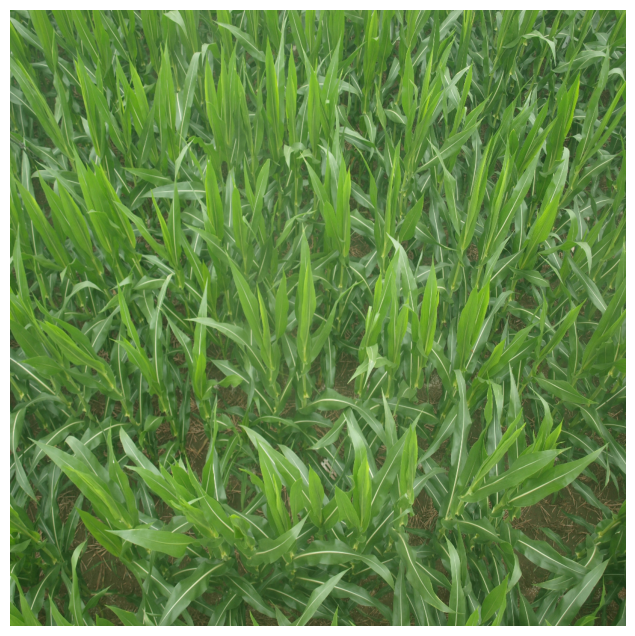

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED OUTPUT

Tassel count: 1


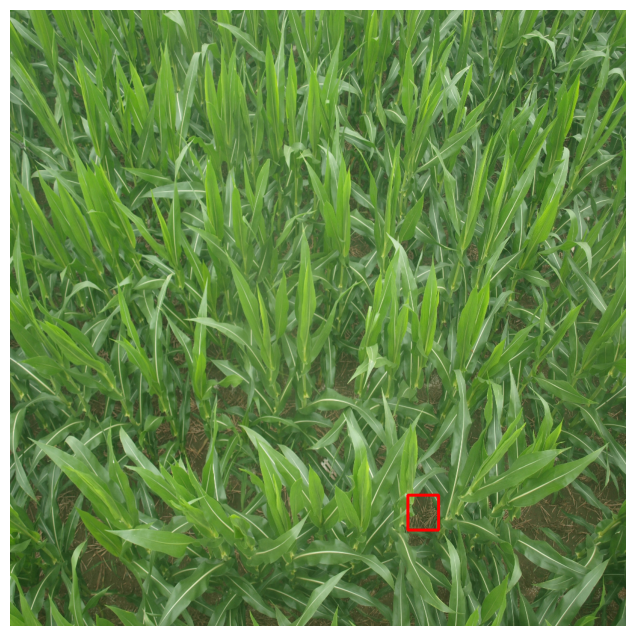

In [67]:
print("EXPECTED OUTPUT\n")
draw_boxes_on_image(expected_boxes, images)

print("PREDICTED OUTPUT\n")
draw_boxes_on_image(prediction_boxes, images)
